# Swarm Simulation

## Structure

* The first cell contains prototypes for the Swarm Particles
* The second cell contains the implementation of the behaviour for each Particle type and the evnironment
* The third code cell runs the simulation

## Programming

* Only the behaviour of the particles needs to be modified so all modifications are limited to the 2nd cell
* The data gathered during the simulation is aviable in the results variable after the simulation is run
* The particles follow the usual update rules: $x_{t+1} = x_t + v_{t+1}$ and $v_{t+1} = w~v_t + \sum f(x_i, x_j)$
* Only $f(x_i, x_j)$ needs to be changed to modify the behaviour of the particles $f$ is computed by the function `computeForce`

## Python Packages

* If the code does not work
  * Make sure that you use python3
  * Make sure that the following packages are installed: numpy, matplotlib
  * Make sure that ffmpeg is installed

In [1]:
# Implementation of the Prototypes

import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib  import animation, rc
from IPython.display import HTML

class SwarmParticle:
    
    def __init__(self, initial_pos, config):
        self.w=config['w']
        self.pos=initial_pos
        self.force=np.zeros(2)
        self.velocity=np.zeros(2)
        self.i = 0
        self.color = 1
    
        
    def preUpdate(self, swarm, env):
        force = np.zeros_like(self.pos)
        swarm = itertools.chain.from_iterable(swarm.values())
        for elem in swarm:
            if elem == self:
                force = force + self.computeForce(np.zeros(2), elem)
            else:
                dist = elem.pos - self.pos
                force = force + self.computeForce(dist, elem)
        self.velocity = force + self.handleEnv(env) + self.velocity * self.w
        
    def update(self):
        self.pos = self.pos + self.velocity
        self.i = self.i + 1
        
    def viz(self):
        return np.concatenate([self.pos, [self.color]])
        
    def computeForce(self, dist,  elem):
        raise NotImplemented("computeForce is not implemented in the abstract SwarmParticle")
        
    def handleEnv(self, env):
        raise NotImplemented("computeForce is not implemented in the abstract SwarmParticle")
        
    def __repr__(self):
        return  "P(%f, %f): (%f, %f)"%(self.pos[0], self.pos[1], self.force[0], self.force[1])
    

class Swarm:
    
    def __init__(self, swarmConfig, env):
        self.swarm={}
        for ParticleType, number in swarmConfig['particles'].items():
            self.swarm[ParticleType]=[ParticleType(env.initial_pos(), swarmConfig) for i in  range(0, number)]
        self.env = env
        
    def update(self):
        swarm = itertools.chain.from_iterable(self.swarm.values())
        for particle in swarm:
            particle.preUpdate(self.swarm, self.env)
        swarm = itertools.chain.from_iterable(self.swarm.values())
        for particle in swarm:
            particle.update()
    
    def viz(self):
        swarm = itertools.chain.from_iterable(self.swarm.values())
        result=[]
        for particle  in swarm:
            result.append(particle.viz());
        return np.vstack(result)

class Environment:
    
    def __init__(self, seed, size):
        np.random.seed(seed)
        self.size=size
        
    def initial_pos(self):
        raise NotImplemented("initial_pos is not implemented in the abstract Environment")

            

In [3]:
# Implementation of the Behaviour

class MAVEnvironment(Environment):
    def __init__(self, seed,  size):
        Environment.__init__(self, seed,  size)
    
    def initial_pos(self):
        scale = np.array([[1, 0], [0, self.size[1]/2]])
        offset= np.array([0.5, 0])
        return (np.random.randn(2)+offset)@scale

class FollowerParticle(SwarmParticle):
    
    def __init__(self, initial_pos, config):
        SwarmParticle.__init__(self, initial_pos, config)
        self.a=config['a']
        self.b=config['b']
        self.c=config['c']
        self.k=config['k']
        self.d=config['d']
    
    """ compute the force of the particle pair
    param self: particle object of x_i
    param elem: particle object of x_j
    param dist: x_i - x_j
    return (partial) force acting on the particle
    """
    def computeForce(self, dist, elem):
        if self == elem:
            return np.zeros(2)
        
        return dist * self.b * (0.8-np.random.rand(2))
        
    def handleEnv(self, env):
        return np.zeros(2)
    
class LeaderParticle(SwarmParticle):
    
    def __init__(self, initial_pos, config):
        SwarmParticle.__init__(self, initial_pos, config)
        self.i=0
        self.color=2
    
    def computeForce(self, dist, elem):
        return np.zeros(2)
    
    def update(self):
        self.i = self.i + 1 
        self.pos = 5 * np.array([np.sin(self.i/10), np.cos(self.i/20)])
        
    def handleEnv(self, env):
        return np.zeros(2)


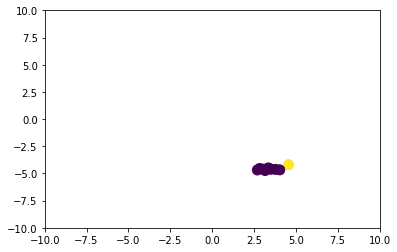

In [4]:
# Execution - run the simulation

env = MAVEnvironment(1234, [10, 10])
swarm  = Swarm({'particles':{LeaderParticle: 1, FollowerParticle: 10}, 'a':0.05, 'b':0.5, 'c':5, 'k':0.02, 'd':5, 'w': 0.5}, env)

results = []
for i in range(0,200):
    swarm.update()
    results.append(swarm.viz())
    
fig, ax = plt.subplots()
    
ax.set_xlim(-env.size[0], env.size[0])
ax.set_ylim(-env.size[1], env.size[1])
    
scat = plt.scatter(results[0][:,0], results[0][:,1], c=results[1][:,2], s=100, animated=True)

def update(frame):
    scat.set_offsets(results[frame][:,:2])
    scat.set_array(results[frame][:,2])
    return scat,

ani = animation.FuncAnimation(fig, update, frames=range(0,len(results)), blit=True)
HTML(ani.to_html5_video())
rc('animation',html='html5')
ani